In [31]:
import src
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [55]:
def _smooth(sig, win=11):
    """
    Smooth signal using a moving average filter.

    Replicates MATLAB's smooth function. (http://tinyurl.com/374kd3ny)

    Args:
        sig (np.array): Signal to smooth.
        win (int, optional): Window size. Defaults to 11.

    Returns:
        np.array: Smoothed signal.
    """
    out = np.convolve(sig, np.ones(win, dtype=int), 'valid') / win
    r = np.arange(1, win - 1, 2)
    start = np.cumsum(sig[:win - 1])[::2] / r
    stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

In [4]:
exp1 = src.load('Test 5')
exp2 = src.load('Test 7')
exp3 = src.load('Test 8')
exp4 = src.load('Test 9')
exp5 = src.load('Test 11')
exp6 = src.load('Test 14')
exp7 = src.load('Test 15')
exps = [exp1, exp2, exp3, exp4, exp5, exp6, exp7]

In [17]:
cutoffs = [
    (None, None),
    (None, None),
    (0, 167),
    (0, 156),
    (None, None),
    (0, 121),
    (None, None),
]

In [23]:
exp_rad = [exp.nc4.radius[cutoff[0]:cutoff[1], :] for exp, cutoff in zip(exps, cutoffs)]

In [25]:
surfs = [src.SurfMeasurements(rad) for rad in exp_rad]

Profiling:   0%|          | 0/214 [00:00<?, ?it/s]

Profiling:   0%|          | 0/164 [00:00<?, ?it/s]

Profiling:   0%|          | 0/167 [00:00<?, ?it/s]

Profiling:   0%|          | 0/156 [00:00<?, ?it/s]

Profiling:   0%|          | 0/140 [00:00<?, ?it/s]

Profiling:   0%|          | 0/122 [00:00<?, ?it/s]

Profiling:   0%|          | 0/142 [00:00<?, ?it/s]

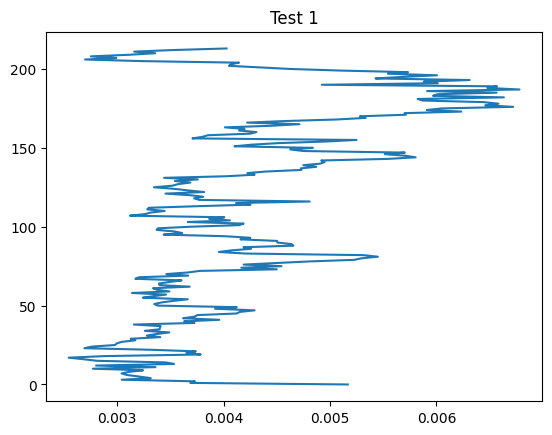

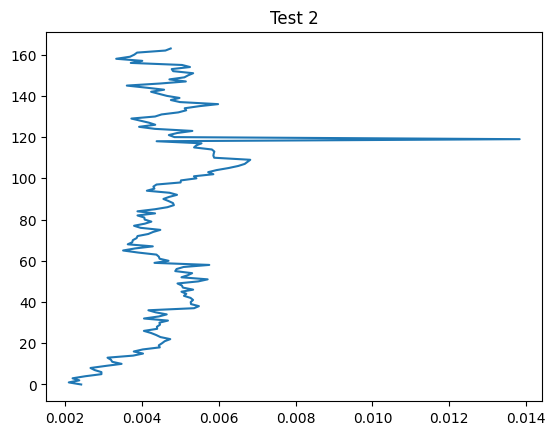

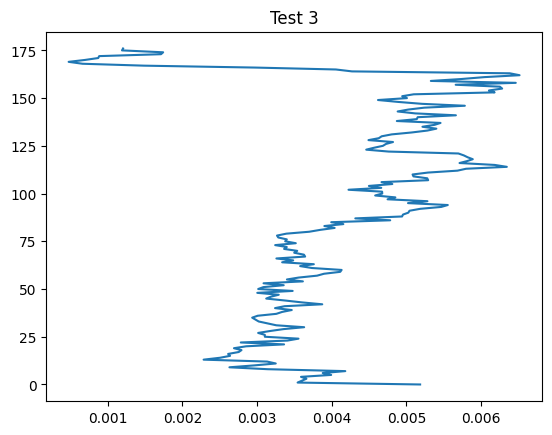

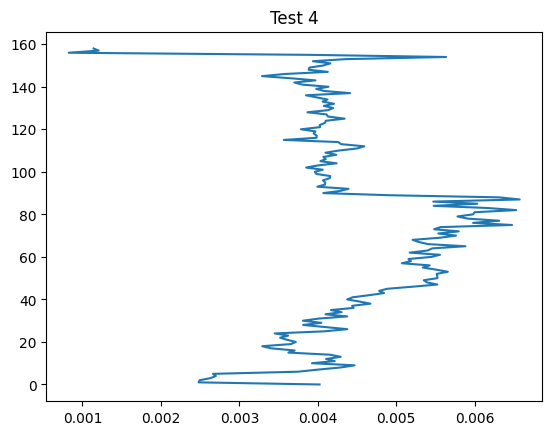

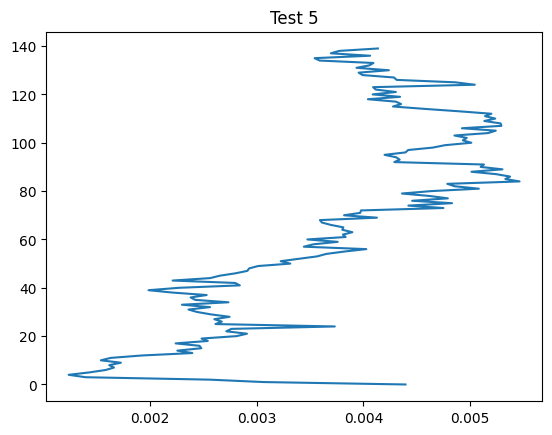

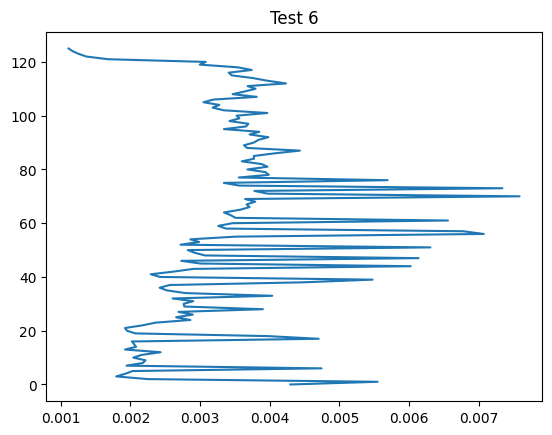

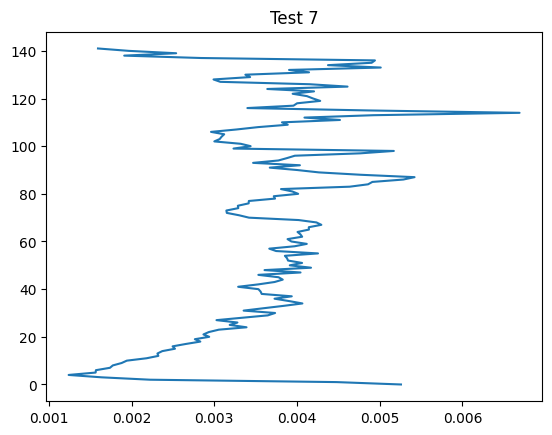

In [6]:
range_surfs = [np.array(np.max(surf.r, axis=1) - np.min(surf.r, axis=1)) for surf in surfs]

for i, range_s in enumerate(range_surfs):
    plt.figure()
    plt.plot(range_s, range(len(range_s)), label='Test {}'.format(i+1))
    plt.title(f'Test {i+1}')

In [96]:
def find_pips(data: np.array, n_pips: int, dist_measure: int):
    # dist_measure
    # 1 = Euclidean Distance
    # 2 = Perpindicular Distance
    # 3 = Vertical Distance

    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]] # Price

    for curr_point in range(2, n_pips):

        md = 0.0 # Max distance
        md_i = -1 # Max distance index
        insert_index = -1

        for k in range(0, curr_point - 1):

            # Left adjacent, right adjacent indices
            left_adj = k
            right_adj = k + 1

            time_diff = pips_x[right_adj] - pips_x[left_adj]
            price_diff = pips_y[right_adj] - pips_y[left_adj]
            slope = price_diff / time_diff
            intercept = pips_y[left_adj] - pips_x[left_adj] * slope;

            for i in range(pips_x[left_adj] + 1, pips_x[right_adj]):
                
                d = 0.0 # Distance
                if dist_measure == 1: # Euclidean distance
                    d =  ( (pips_x[left_adj] - i) ** 2 + (pips_y[left_adj] - data[i]) ** 2 ) ** 0.5
                    d += ( (pips_x[right_adj] - i) ** 2 + (pips_y[right_adj] - data[i]) ** 2 ) ** 0.5
                elif dist_measure == 2: # Perpindicular distance
                    d = abs( (slope * i + intercept) - data[i] ) / (slope ** 2 + 1) ** 0.5
                else: # Vertical distance    
                    d = abs( (slope * i + intercept) - data[i] )

                if d > md:
                    md = d
                    md_i = i
                    insert_index = right_adj

        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])

    return pips_x, pips_y

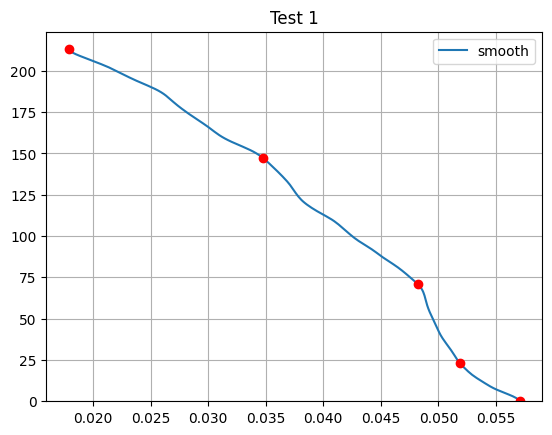

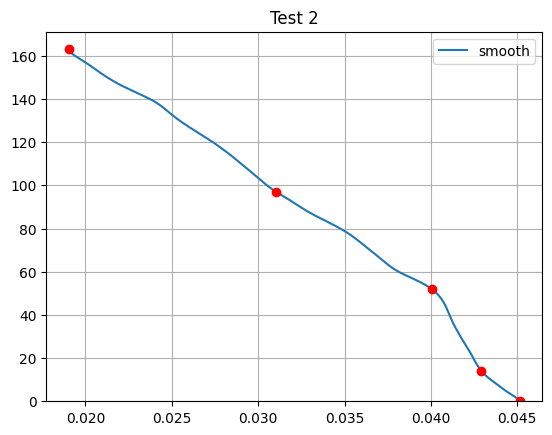

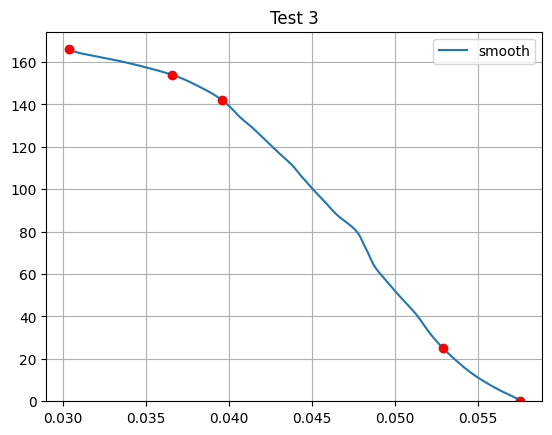

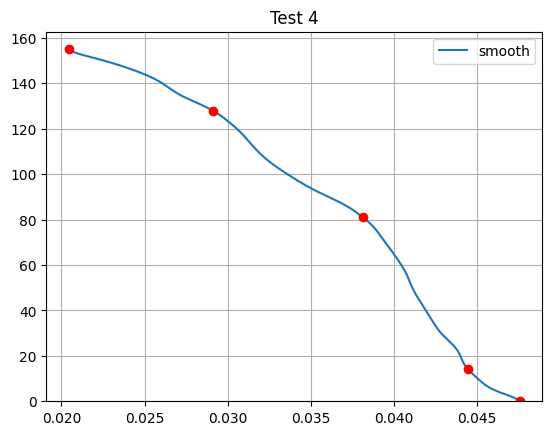

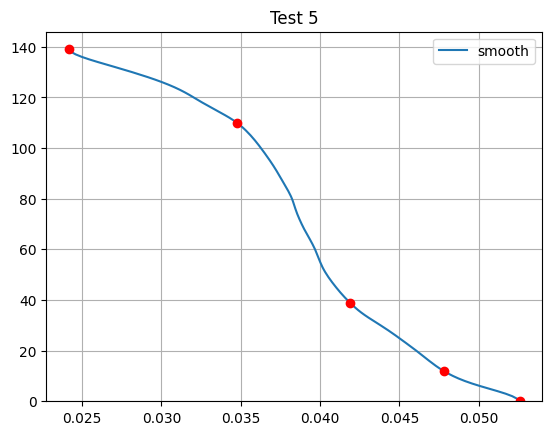

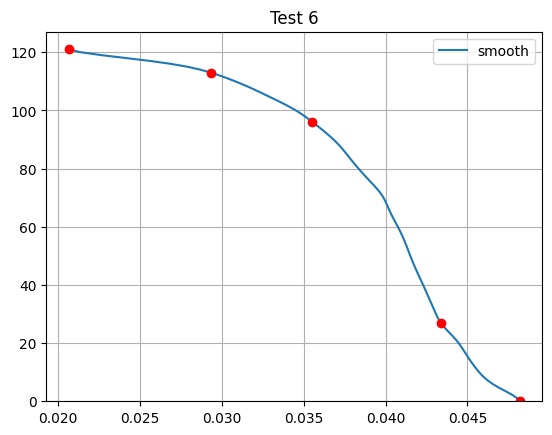

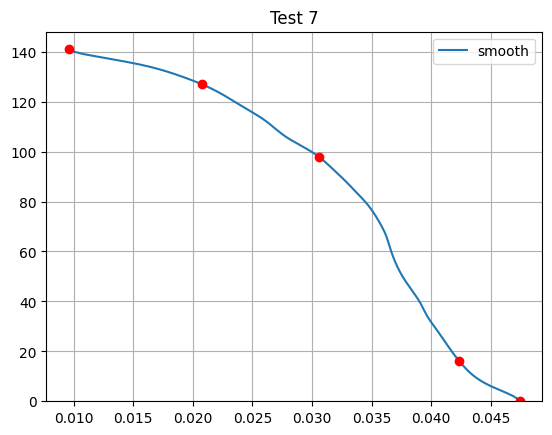

In [119]:
from scipy.ndimage import gaussian_filter1d

error_surf = []

for i, surf in enumerate(surfs):
    # ideal = np.ones_like(surf.w) * np.mean(surf.w[0, :])
    ideal = np.ones_like(surf.w) * (0.65 - 0.032)
    rmse_mean = mean_squared_error(surf.w.T,
                                   ideal.T,
                                   squared=False,
                                   multioutput='raw_values',
                                   )
    error_surf.append(rmse_mean)

    smooth = gaussian_filter1d(rmse_mean, 3)

    pips_x, pips_y = find_pips(smooth, 5, 2)

    plt.figure()
    # plt.plot(rmse_mean, range(len(rmse_mean)), label='rmse_mean')
    plt.plot(smooth, range(len(smooth)), label='smooth')
    for x, y in zip(pips_x, pips_y):
        plt.plot(y, x, 'ro')
    plt.legend()
    plt.title(f'Test {i+1}')
    plt.ylim(0, )
    plt.grid()

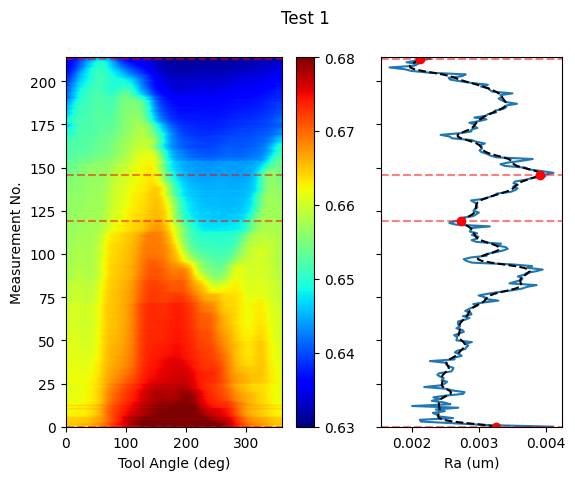

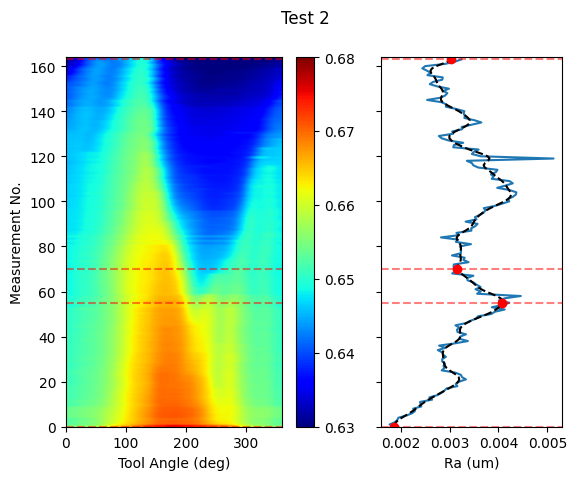

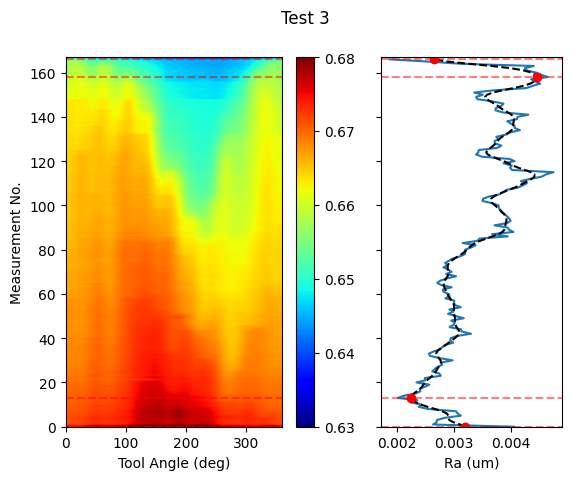

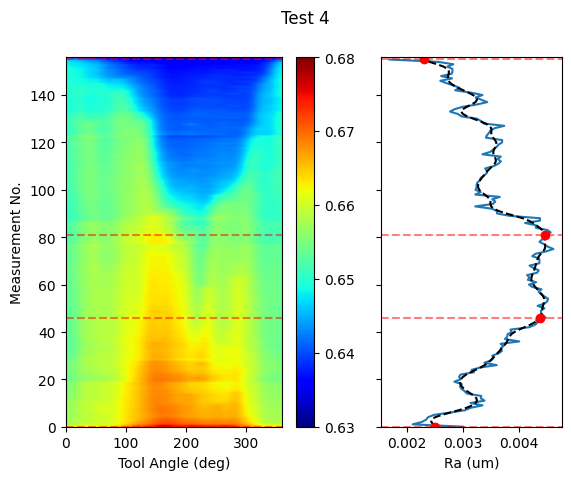

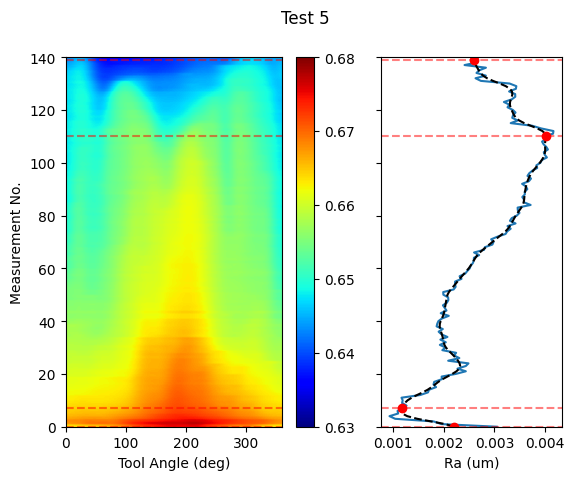

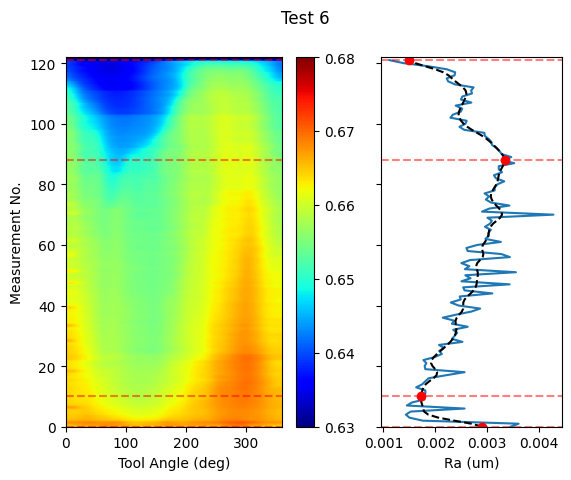

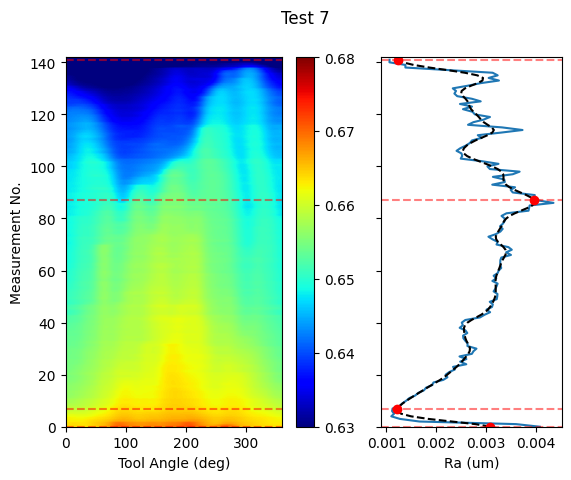

In [129]:
for i, surf in enumerate(surfs):
    fig, ax = plt.subplots(1, 2, sharey=True, width_ratios=[0.6, 0.4])
    im = ax[0].imshow(surf.w,
                      origin='lower',
                      interpolation=None,
                      aspect='auto',
                      cmap='jet',
                      extent=[0, 360, 0, len(surf.w)],
                      vmin=0.63,
                      vmax=0.68,
                    #   vmin=-0.003,
                    #   vmax=0.003,
                      )
    ax[1].plot(surf.meas_df['Rq']*1000,
               surf.meas_df.index
               )

    smooth = gaussian_filter1d(surf.meas_df['Rq'].values*1000, 2)
    ax[1].plot(smooth, range(len(smooth)), 'k--')

    pips_x, pips_y = find_pips(smooth,
                               4,
                               3,
                               )

    for x, y in zip(pips_x, pips_y):
        ax[1].plot(y, x, 'ro')
        ax[1].axhline(x, color='r', linestyle='--', alpha=0.5)
        ax[0].axhline(x, color='r', linestyle='--', alpha=0.5)

    ax[0].set_ylabel('Measurement No.')
    ax[0].set_xlabel('Tool Angle (deg)')
    ax[1].set_xlabel('Ra (um)')
    # ax[1].set_xlim(0, 1)
    fig.colorbar(im)
    fig.suptitle(f'Test {i+1}')

### Old code

In [1]:
%run src/nc4/surf_meas.py

Profiling:   0%|          | 0/214 [00:00<?, ?it/s]

Profiling:   0%|          | 0/164 [00:00<?, ?it/s]

Profiling:   0%|          | 0/177 [00:00<?, ?it/s]

Profiling:   0%|          | 0/159 [00:00<?, ?it/s]

In [22]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
surfs = [surf5, surf7, surf8, surf9]
exps = [exp5, exp7, exp8, exp9]
data = zip(exps, surfs)

In [4]:
res_dfs = [pd.concat([exp.features, surf.meas_df], axis=1) for exp, surf in data]

In [5]:
res_dfs[0].drop([23,24], inplace=True)

In [50]:
for df in res_dfs:
    df.loc[:,['Form error', 'Runout']] = df.loc[:, ['Form error', 'Runout']]*1000

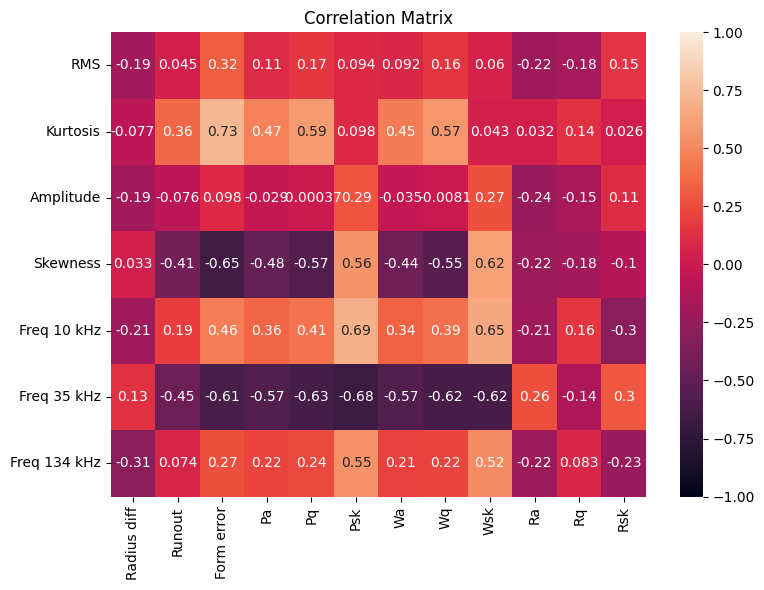

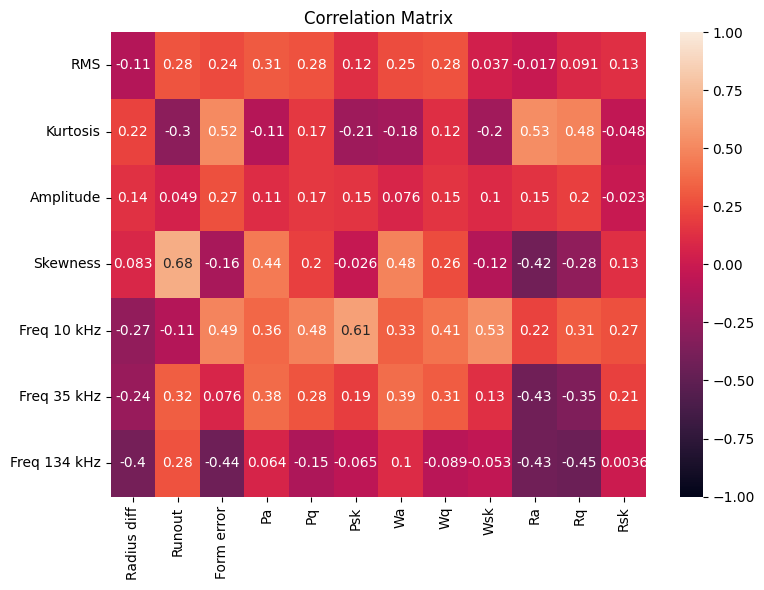

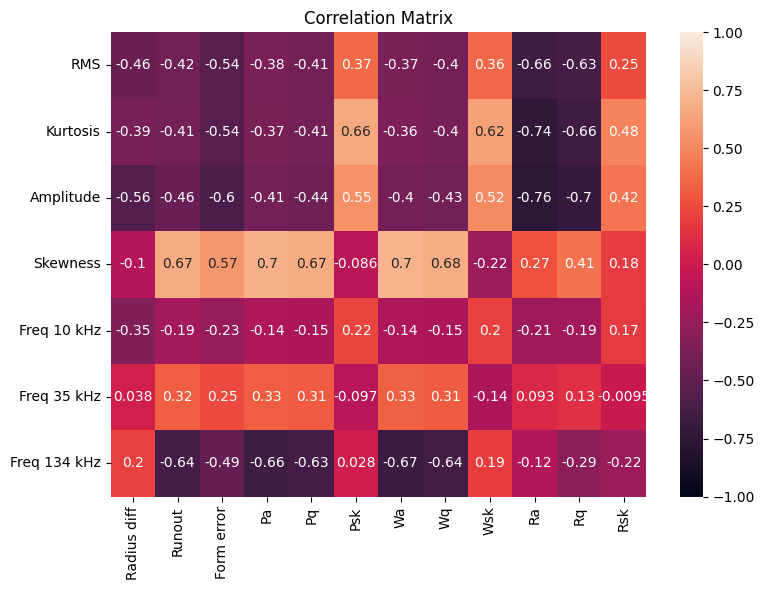

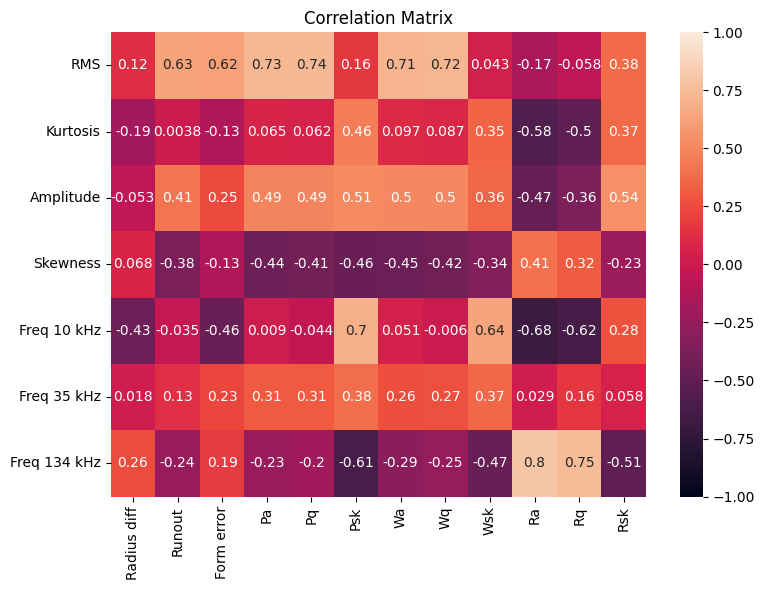

In [54]:
def corr_matrix(df: pd.DataFrame):
    cols = df.columns
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    corr = df.corr().iloc[:7, -12:]
    sns.heatmap(corr,
                ax=ax,
                annot=True,
                vmin=-1,
                vmax=1) \
        .set(title='Correlation Matrix')
    plt.tight_layout()
    # plt.show()
    return corr

for df in res_dfs: corr_matrix(df)

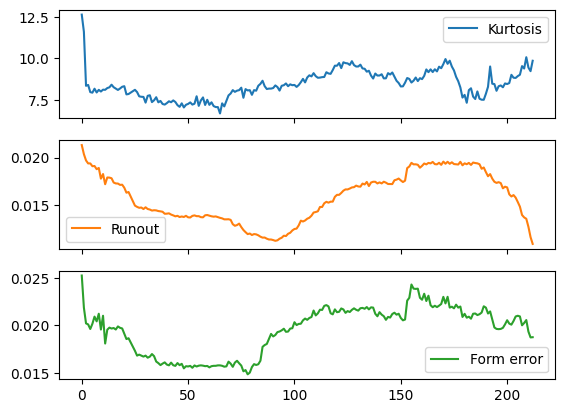

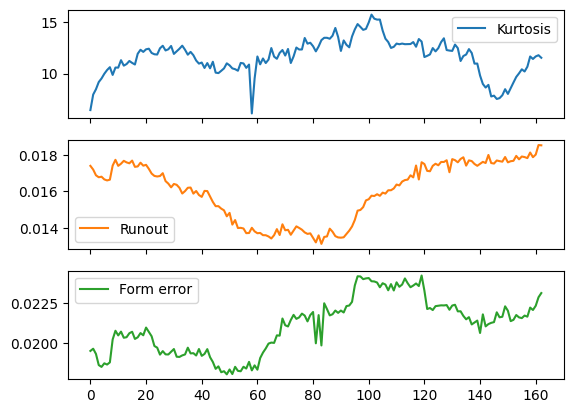

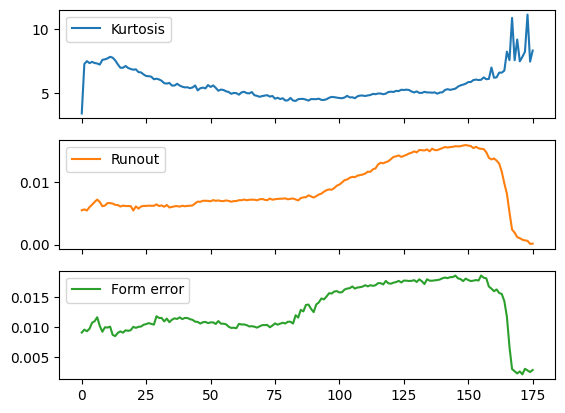

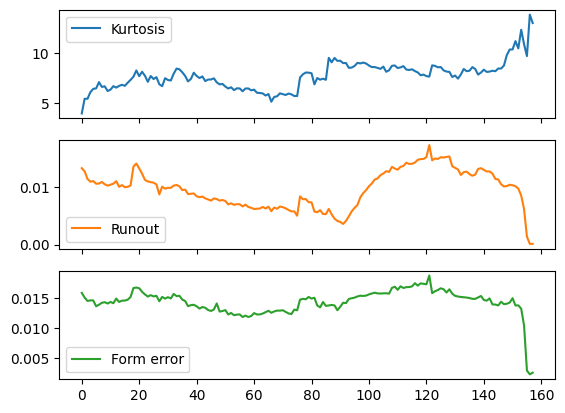

In [12]:
for df in res_dfs: df.plot(y=['Kurtosis', 'Runout', 'Form error'], subplots=True)

In [47]:
def plot_df(df, columns):

    cmap = cm.get_cmap('tab10', 10)
    line_styles = ["-", "--", "-.", ":"]

    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

    axes = [ax]
    handles = []

    for i, _ in enumerate(range(len(columns) - 1)):
        twin = ax.twinx()
        axes.append(twin)
        twin.spines.right.set_position(("axes", 1 + i/10))

    for i, col in enumerate(columns):
        ylabel = []
        if len(col) == 1:
            p, = axes[i].plot(df[col[0]], label = col[0], color = cmap(i)[:3])
            handles.append(p)
            ylabel.append(col[0])
        else:
            for j, sub_col in enumerate(col):
                p, = axes[i].plot(df[sub_col], label = sub_col, color = cmap(i)[:3], linestyle = line_styles[j])
                ylabel.append(sub_col)
                handles.append(p)
        axes[i].set_ylabel(', '.join(ylabel))

    ax.legend(handles = handles, frameon = True)

    plt.tight_layout()

    plt.show()

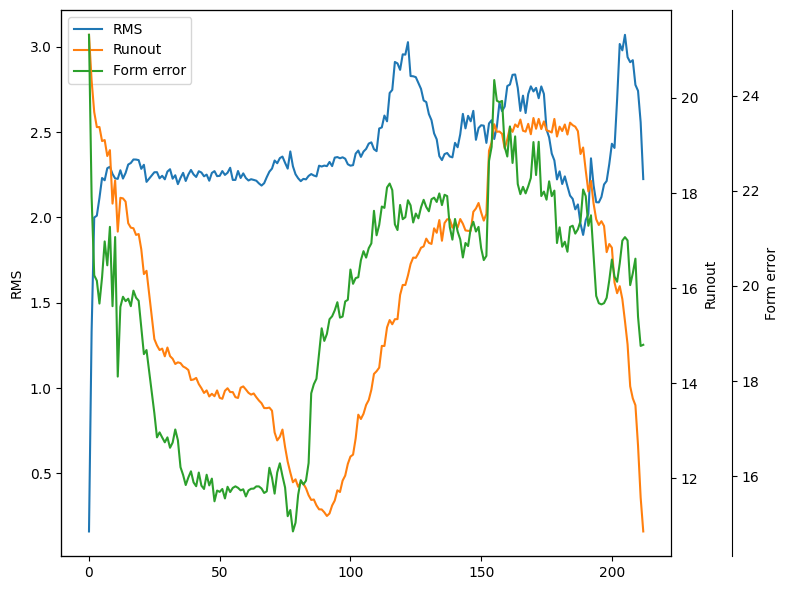

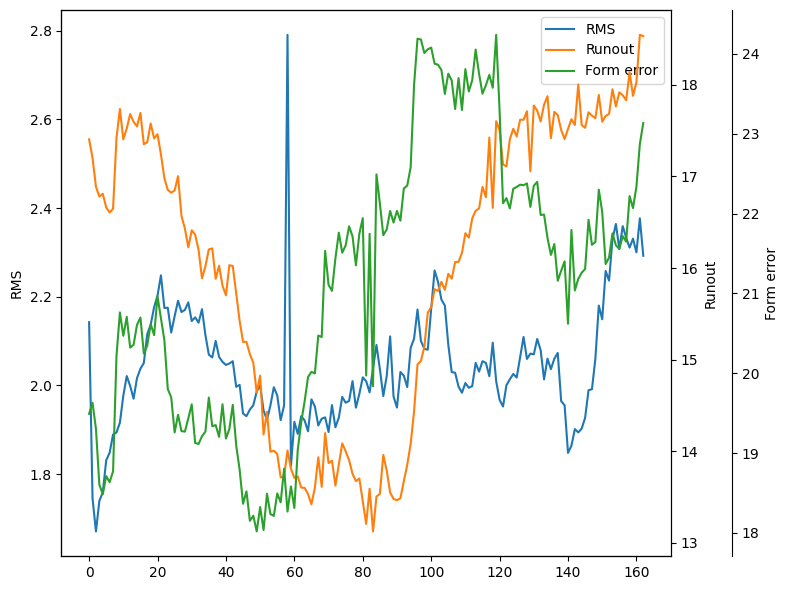

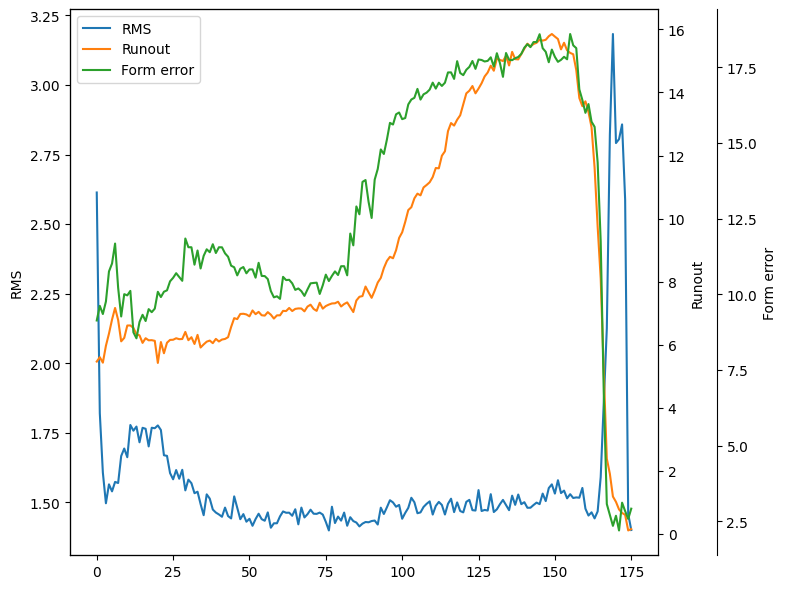

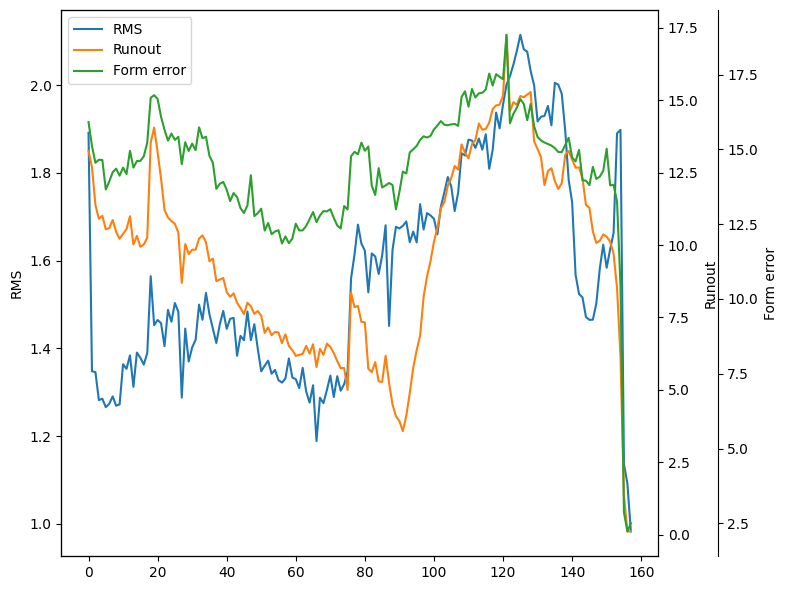

In [52]:
for df in res_dfs:
    plot_df(df, [['RMS'], ['Runout'], ['Form error']])